> # **Energy Consumption Forecasting**

<p align="center">
  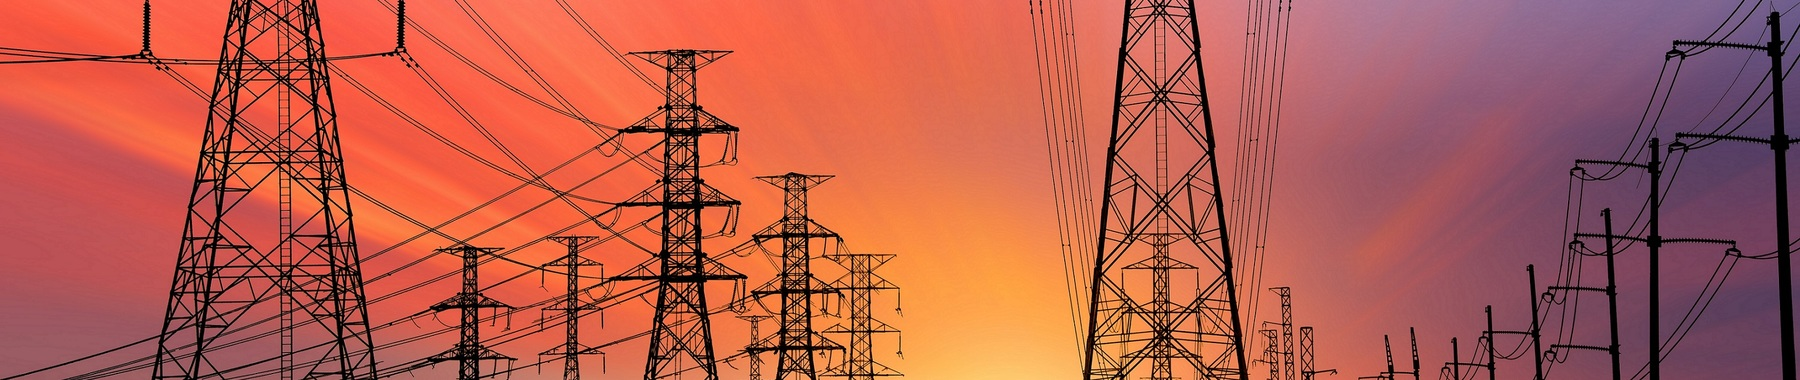
</p>



### **Abstract**
A very basic understanding of the subject is expected. The goal of this notebook is to familiarize the reader with the interesting capabilities of three machine learning algorithms in a not overwhelming way. The chosen algorithms diferenciate conceptually from each other and in their performance and will help to broaden one's perspective on the subject. The algorithms are ARIMA and Prophet, spechialized in forecasting time series, and XGBoost - an ensemble of algorithms:

#### **Data**

The data on which the algorithms will be trained and tested upon comes from Kaggle Hourly Energy Consumption database. It is collected by PJM Interconnection, a company coordinating the continuous buying, selling, and delivery of wholesale electricity through the Energy Market from suppliers to customers in the reagon of South Carolina, USA. All .csv files contains rows with a timestamp and a value. The name of the value column corresponds to the name of the contractor. the timestamp represents a single hour and the value represents the total energy, cunsumed during that hour.

#### **Data Modeling**

#### 1. ARIMA

AutoRegressive Integrated Moving Average with eXogenous regressors model. Just remember that it is composed of several statistical models and is highly configurable.

ARIMA has an order=(p,d,q) parameter that manages the AR and MA parts of the algorithm. [[statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html?highlight=arima)

SARIMAX is an extension of ARIMA that enables seasonal_order(P,D,Q,s) allowing for day, week, ... components. [statsmodels.tsa.arima_model.SARIMAX]

The practice is to run this algorithm for one unknown future date and use that date in the forcasting of next unknown dates.

#### 2. XGBoost

eXtreme Gradient Boosting.

The algorithm XGBoost implements is called gradient boosting decision tree algorithm. Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made.

Gradient boosting: approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction.

To minimize the loss when adding new modelsgradient descent algorithm is used.

Computational speed and model performance are impressive.

In [1]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.9 MB/s eta 0:00:0000:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')      # Ignore warnings

print('Setup Completed')

Setup Completed


In [4]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv', parse_dates=True, index_col='Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [5]:
df.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [7]:
df.isnull().sum()

PJME_MW    0
dtype: int64

# Let's Visualize our Data  :)

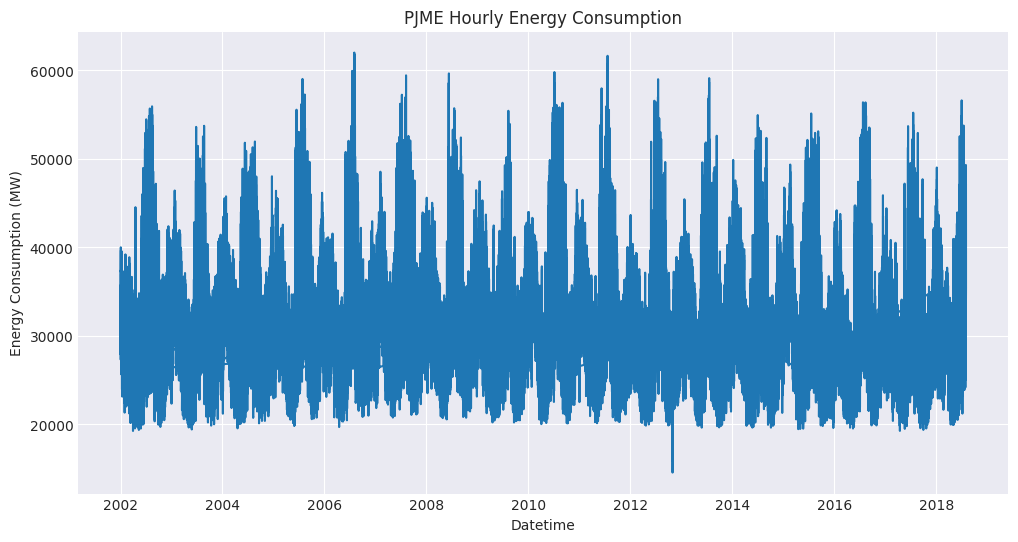

In [8]:
# Plotting the data
plt.figure(figsize=(12,6))
plt.plot(df.index, df['PJME_MW'])
plt.title('PJME Hourly Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')

# Show the plot
plt.show()

<Axes: >

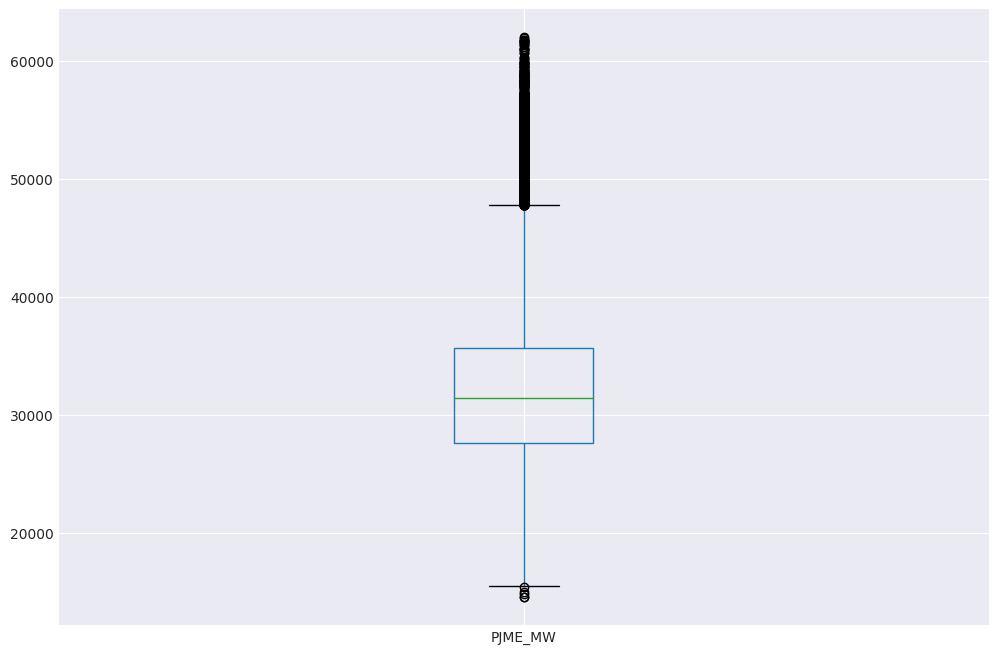

In [9]:
df.boxplot(figsize=(12, 8))

We don't have any outliers

### **Resampling for Different Time Scales:**

- Resample the data to daily, weekly, or monthly averages to observe longer-term trends.
- Plot these resampled datasets to see how patterns change with different time scales.


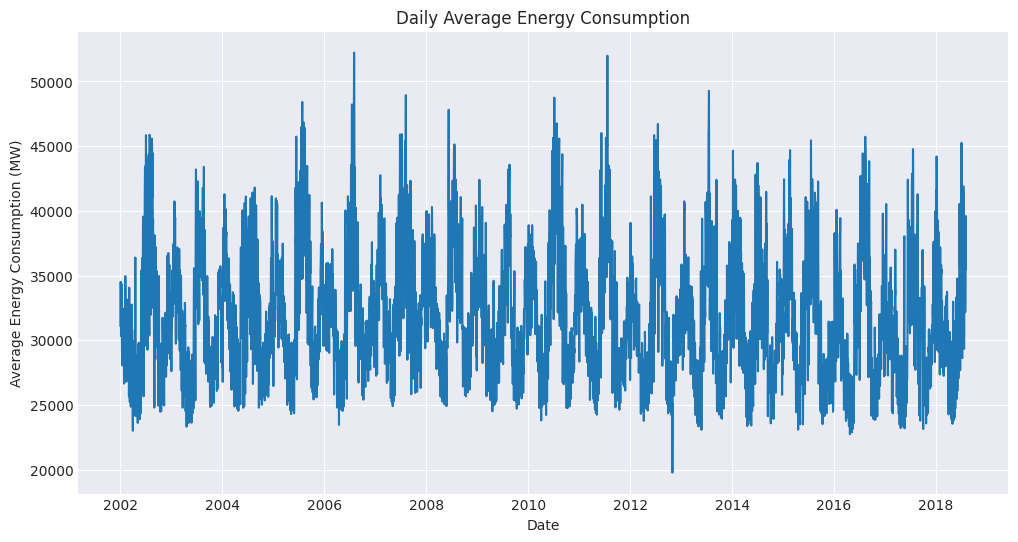

In [10]:
daily_data = df['PJME_MW'].resample('D').mean()
plt.figure(figsize=(12,6))
plt.plot(daily_data)
plt.title('Daily Average Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Average Energy Consumption (MW)')
plt.show()

### **Decomposing the Time Series:**

- Decompose the time series to observe its trend, seasonal, and residual components.
- This can be done using `seasonal_decompose` from `statsmodels`.


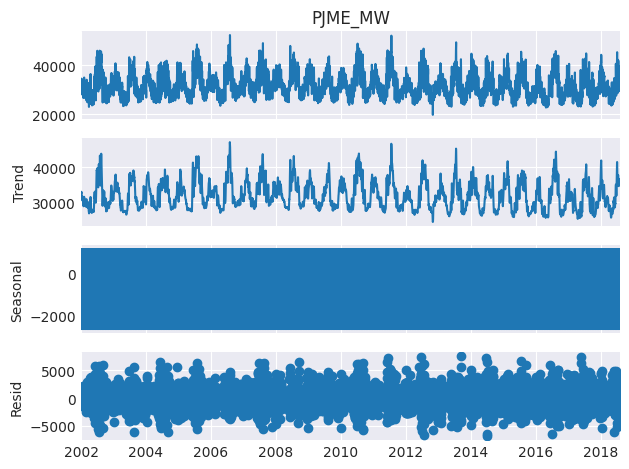

In [11]:
# Decompose the daily time series
decomposition = seasonal_decompose(daily_data, model='additive')

# Plot the decomposed components
decomposition.plot()
plt.show()

### **Moving Averages:**

Calculate and plot moving averages to smooth out short-term fluctuations and highlight longer-term trends.


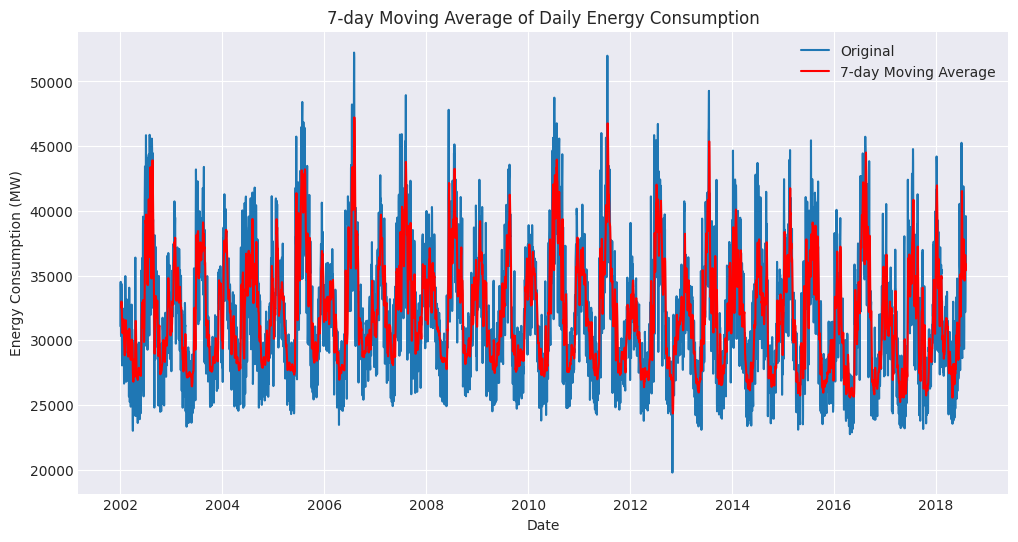

In [12]:
moving_avg = daily_data.rolling(window=7).mean()
plt.figure(figsize=(12,6))
plt.plot(daily_data, label='Original')
plt.plot(moving_avg, color='red', label='7-day Moving Average')
plt.title('7-day Moving Average of Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

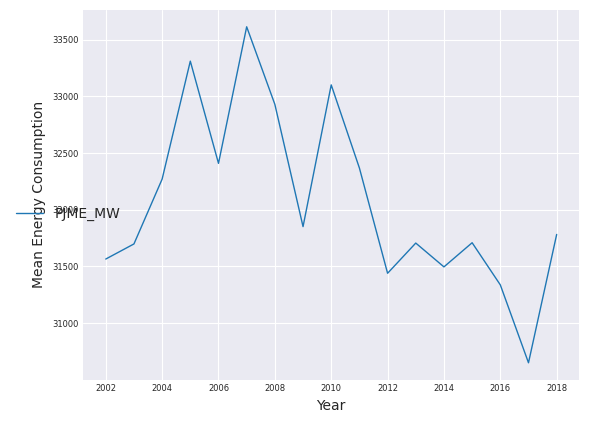

<Figure size 1500x800 with 0 Axes>

In [13]:
consumpation_by_year = df.groupby(df.index.year).mean()

# Plot the mean for each year
ax = consumpation_by_year.plot(fontsize=6, linewidth=1)

# Set axis labels and legend
ax.set_xlabel('Year')
ax.set_ylabel('Mean Energy Consumption')
ax.legend(bbox_to_anchor=(0.1, 0.5), fontsize=10)
plt.figure(figsize=(15, 8))
plt.show()

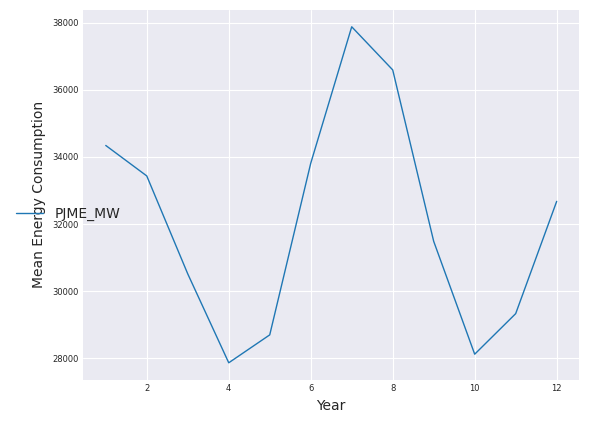

<Figure size 1500x800 with 0 Axes>

In [14]:
# Compute the mean for each year
consumpation_by_month = df.groupby(df.index.month).mean()

# Plot the mean for each year
ax = consumpation_by_month.plot(fontsize=6, linewidth=1)

# Set axis labels and legend
ax.set_xlabel('Year')
ax.set_ylabel('Mean Energy Consumption')
ax.legend(bbox_to_anchor=(0.1, 0.5), fontsize=10)
plt.figure(figsize=(15, 8))
plt.show()

## Check the Stationarity of Data

### 1. Rolling Statistics

we caculate Rolling Mean and STD and Should be both of them constent over time

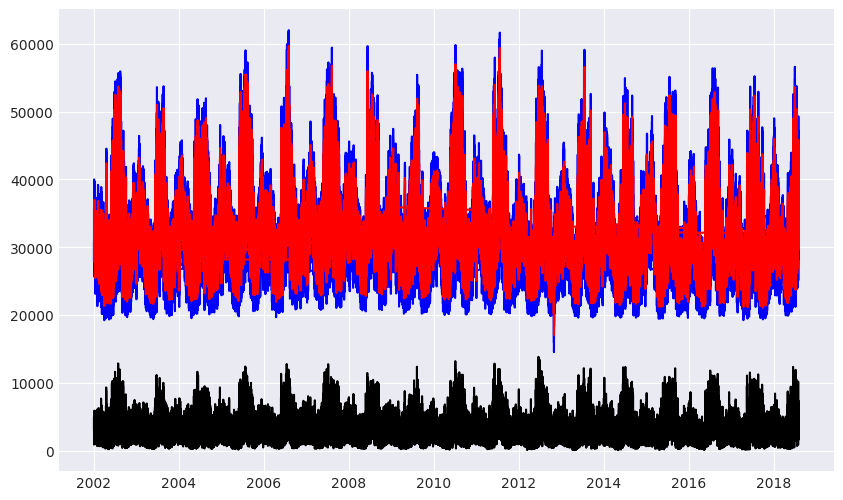

In [15]:
rolling_mean = df['PJME_MW'].rolling(window=12).mean()
rolling_std = df['PJME_MW'].rolling(window=12).std()

# plotting the original data along Rolling
plt.figure(figsize=(10, 6))
plt.plot(df['PJME_MW'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')

the plot shows that the rolling mean and standard deviation are not constant and exhibit seasonal patterns and trends, which suggests that **the time series is not stationary**.

### 2. ADF Test

To statistically confirm whether the data is stationary or not, We should perform the **Augmented Dickey-Fuller (ADF) test**. The ADF test will provide a p-value: if the p-value is less than a certain threshold (commonly 0.05), the data can be considered

## Time Series Analysis: Autocorrelation and Partial Autocorrelation


The ADF test gives us a more accurate results and it apper that our **data is stationary** not as was clear in the graph

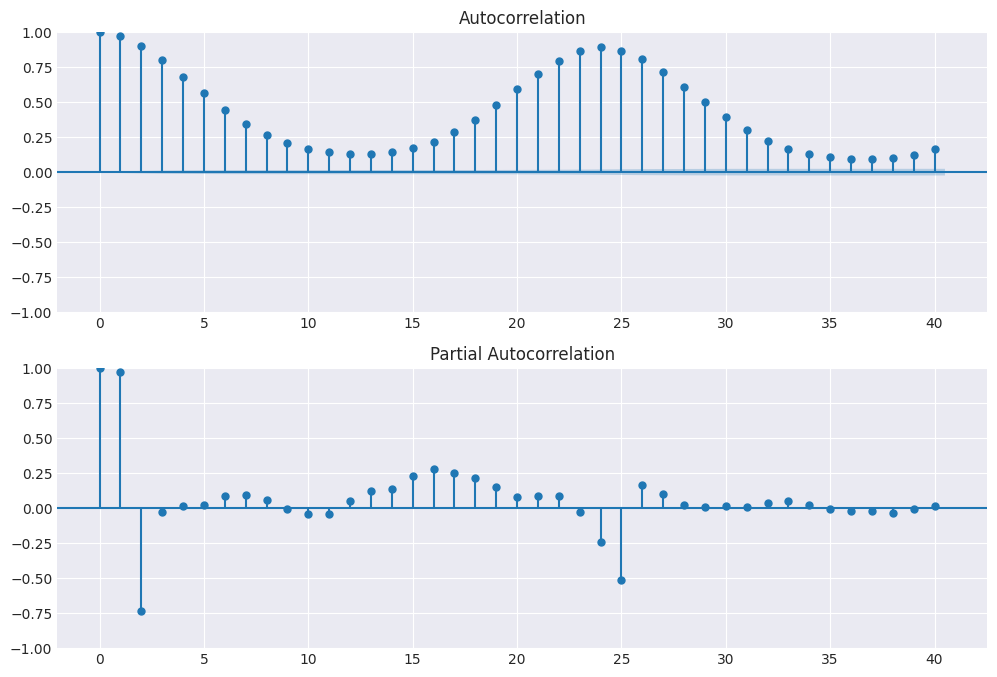

In [17]:
# Check stationarity and determine d
result = adfuller(df['PJME_MW'])
d = 0
if result[1] > 0.05:
    d = 1

# Differencing if needed
if d > 0:
    differenced_series = df['PJME_MW'].diff().dropna()
else:
    differenced_series = df['PJME_MW']

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
tsaplots.plot_acf(differenced_series, lags=40, ax=ax1)
tsaplots.plot_pacf(differenced_series, lags=40, ax=ax2)
plt.show()


### Autocorrelation Function (ACF)

The ACF plot shows the correlation of the time series with its own lagged values. The key points from the ACF plot are:

- **Lag 0**: The autocorrelation at lag 0 is always 1, as the time series is perfectly correlated with itself.
- **Gradual Decline**: The autocorrelations appear to decrease slowly as the lags increase, suggesting an Autoregressive (AR) process characteristic.
- **Non-abrupt Cutoff**: The autocorrelations do not drop to zero abruptly, which often indicates that the series is not a pure Moving Average (MA) process.

### Partial Autocorrelation Function (PACF)

The PACF plot is used to find the order of the AR term in a time series. The key observations from the PACF plot are:

- **Significant Spike at Lag 1**: There is a significant spike at lag 1, with a possibility at lag 2, indicating that the AR part of the time series may be of order 1 or 2.
- **Confidence Interval**: The chart does not show confidence intervals, but typically if the spikes extend beyond the confidence interval, it suggests a significant correlation at that lag.

### Model Selection

While ACF and PACF plots are insightful for identifying potential AR and MA processes, model selection should also consider:

- **Stationarity**: The time series data should be stationary before model fitting.
- **Information Criteria**: Metrics like the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) can help in model selection.
- **Model Diagnostics**: After fitting a model, diagnostics should be performed to check the adequacy of the model fit.

> Note: These observations are made based on the provided ACF and PACF plots. It is essential to include confidence bands in the plots and perform further analysis before finalizing the time series model.


# Data Modeling

We will use:
- ARIMA Model when we have a Univariate Data
- XGBoost Regressor when we have Multivariate Data or Multiple time Series

# Train/Test Split

In [18]:
# Create a column that given Month
# df['Month'] = df.index.month

train = df[df.index < '2014-01-01']
test = df[(df.index > '2014-01-01') | (df.index == '2014-01-01')]

# or use that
# # Split the data into train and test set
# train = df['PJME_MW'][:'2014-01-01']
# test = df['PJME_MW']['2014-01-01':]

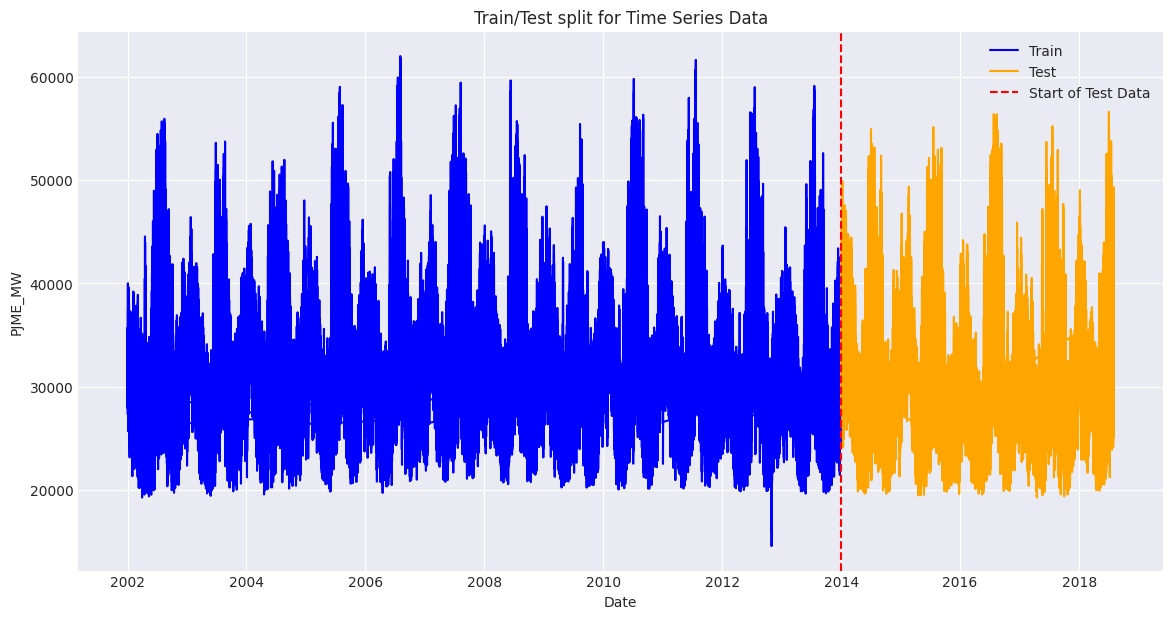

In [19]:
# Plot the training data
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['PJME_MW'], label='Train', color='blue')

# Plot the testing data
plt.plot(test.index, test['PJME_MW'], label='Test', color='orange')

# Add a vertical line at the boundary between the train and test datasets
plt.axvline(x=pd.to_datetime('2014-01-01'), color='red', linestyle='--', label='Start of Test Data')

# Add some labels and a legend
plt.xlabel('Date')
plt.ylabel('PJME_MW') # Replace 'Values' with the appropriate label for your data
plt.title('Train/Test split for Time Series Data')
plt.legend()

the model with least value of `AIC` its the best parameters We can add to our `ARIMA` Model

- (2,1,4)
- (2,1,3)
- (3,1,2)

In [20]:
# from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['PJME_MW'],order=(2,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJME_MW   No. Observations:               145366
Model:                 ARIMA(2, 1, 4)   Log Likelihood            -1210391.806
Date:                Fri, 26 Jan 2024   AIC                        2420797.612
Time:                        09:23:56   BIC                        2420866.821
Sample:                             0   HQIC                       2420818.268
                             - 145366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8951      0.001   2094.035      0.000       1.893       1.897
ar.L2         -0.9594      0.001  -1243.820      0.000      -0.961      -0.958
ma.L1         -1.3647      0.002   -788.543      0.000      -1.368      -1.361
ma.L2          0.1452      0.003     42.830      0.000       0.139       0.152
ma.L3          0.0572      0.006     10.298      0.000       0.046       0.068
ma.L4          0.1975      0.003     62.460      0.000       0.191       0.204
sigma2      9.986e+05   1688.873    591.296      0.000    9.95e+05       1e+06
===================================================================================
Ljung-Box (L1) (Q):                  37.27   Jarque-Bera (JB):            784285.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Diagnostic Plots Analysis


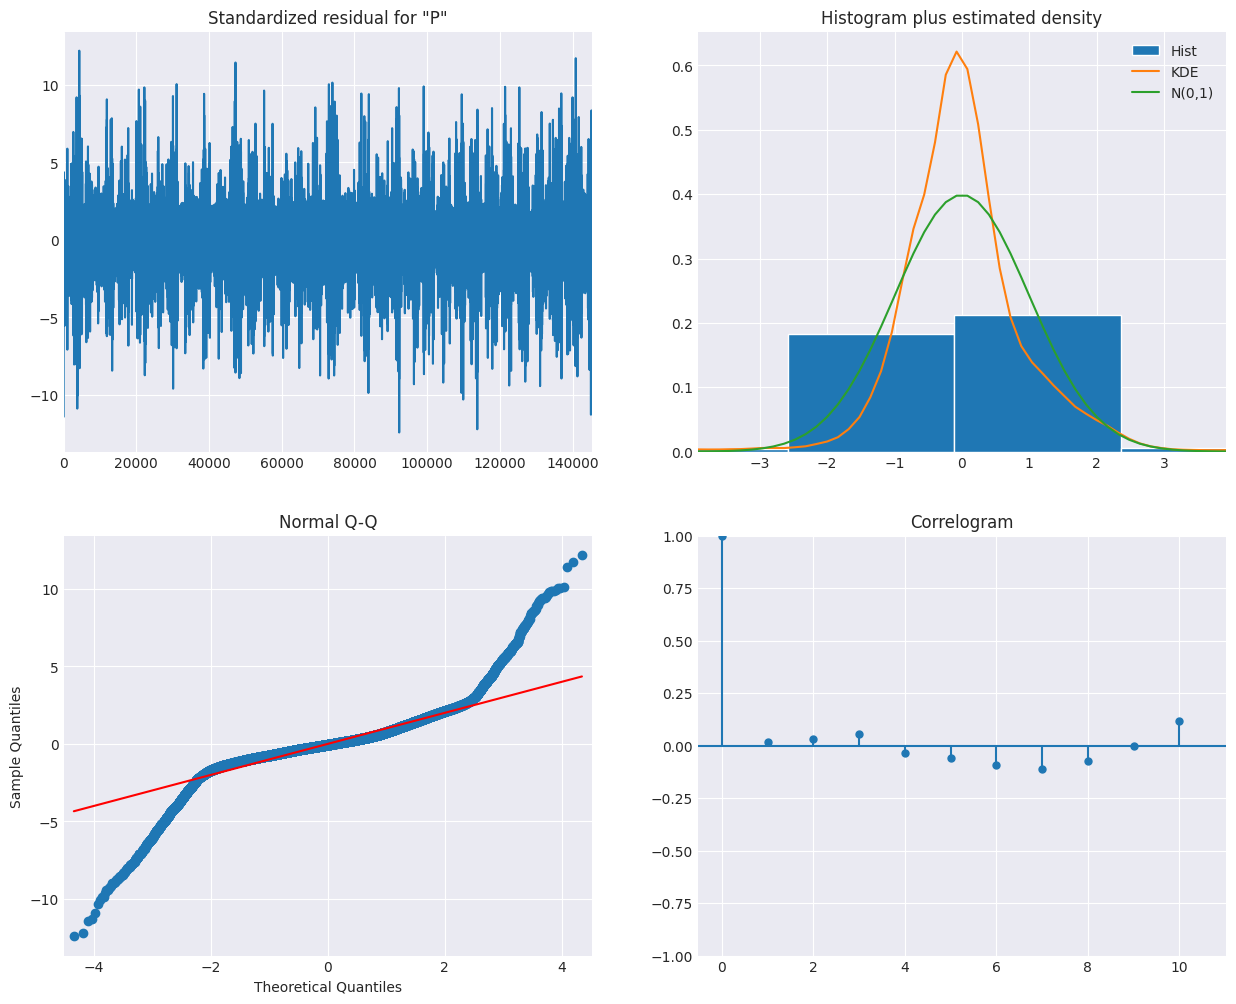

In [21]:
# Diagnostic checks
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


### Standardized Residuals
- The residuals do not show a clear pattern, which is good.
- There are some outliers visible, which could be investigated further.

### Histogram and Estimated Density
- The Kernel Density Estimate (KDE) does not perfectly match the normal distribution curve.
- This indicates that the residuals may not be normally distributed.

### Normal Q-Q Plot
- There are visible deviations from the normal line, especially in the tails.
- This suggests that the residuals may not follow a normal distribution, which is an assumption of many time series models.

### Correlogram
- The autocorrelation of the residuals is within the confidence interval at all lags.
- This indicates that there is no significant autocorrelation, and the residuals are random (which is an indication of a good model fit).

### Action Points
- Investigate the cause of outliers in the residuals.
- Consider transformations or model adjustments to address non-normality in residuals.
- Continue to monitor the model's residuals for any emergence of patterns or autocorrelation over time.

## XGBoost

In [22]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [23]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:32674.11058	validation_1-rmse:31679.73323
[100]	validation_0-rmse:12597.40541	validation_1-rmse:11706.34394
[200]	validation_0-rmse:5827.94595	validation_1-rmse:5298.28203
[300]	validation_0-rmse:3907.55115	validation_1-rmse:3931.36945
[400]	validation_0-rmse:3434.62169	validation_1-rmse:3777.80230
[500]	validation_0-rmse:3281.26926	validation_1-rmse:3749.91260
[600]	validation_0-rmse:3196.77243	validation_1-rmse:3724.26831
[700]	validation_0-rmse:3144.02059	validation_1-rmse:3708.99121
[800]	validation_0-rmse:3103.30553	validation_1-rmse:3701.68345
[900]	validation_0-rmse:3070.48035	validation_1-rmse:3694.57722
[999]	validation_0-rmse:3041.82795	validation_1-rmse:3689.07110


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

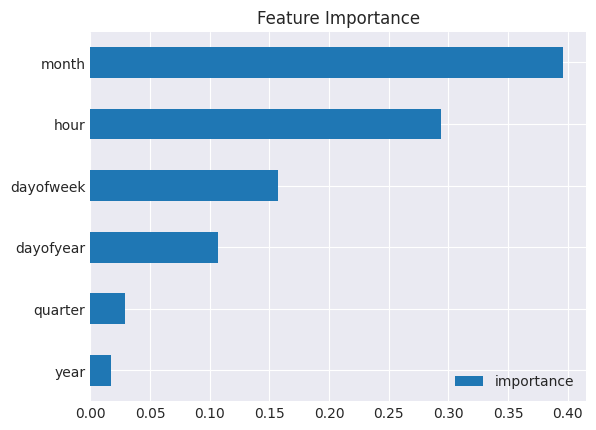

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

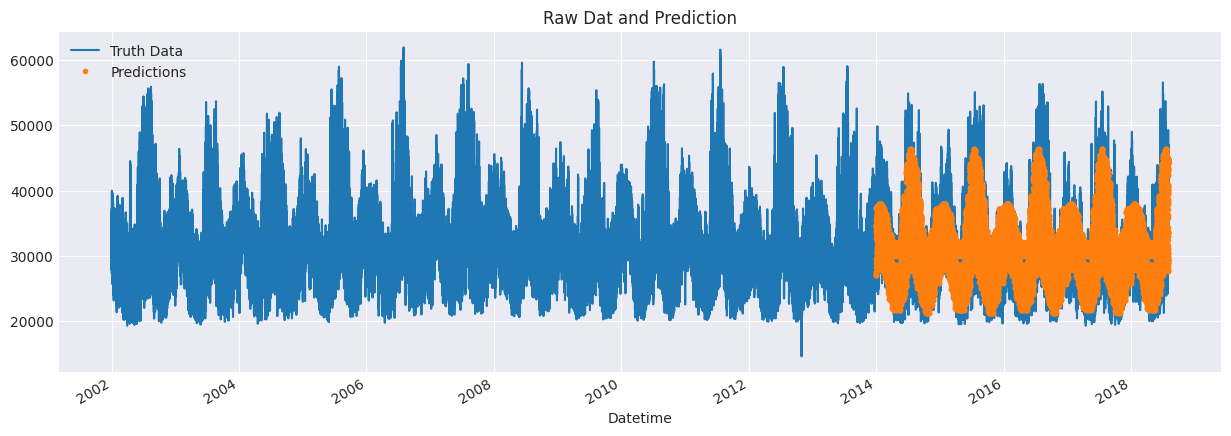

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

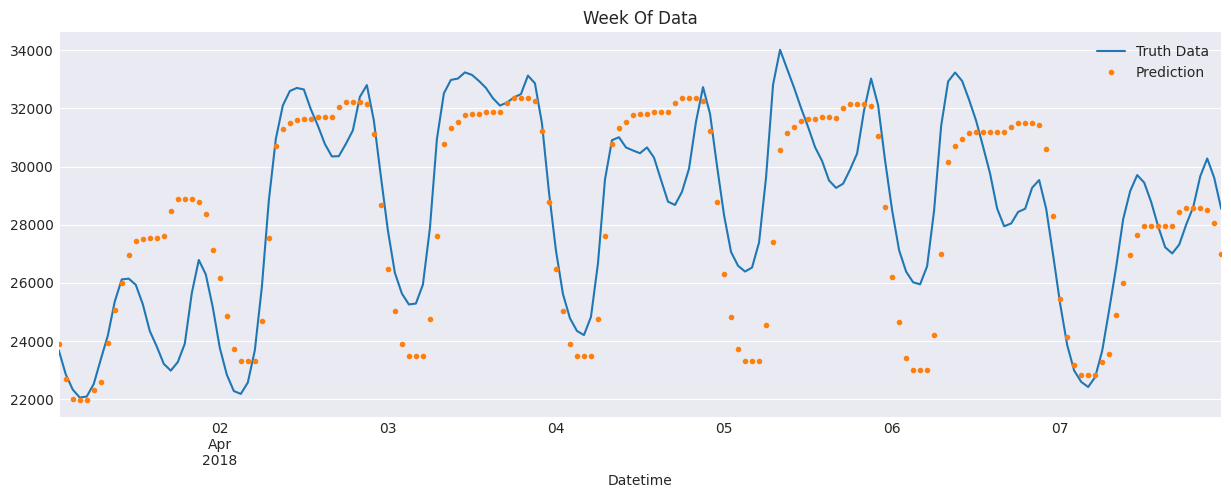

In [27]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Model Evaluation
We will use RMSE to Measure our Performance

In [28]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3689.06


## Calculation Prons and cons of our Model

In [29]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-01-06    11599.594645
2015-02-20    11549.130452
2016-08-13    11222.891276
2016-08-14    11100.467611
2016-09-09    10890.033447
2016-09-10    10880.998210
2016-07-04    10763.239583
2018-01-07    10700.260742
2015-02-16    10409.400309
2014-01-07    10347.590332
Name: error, dtype: float64

# Conclusion and Forecasting Results

Throughout this notebook, we've taken a comprehensive journey through time series analysis and forecasting using ARIMA models. We started by exploring the data, understanding its temporal characteristics, and then proceeded to check for stationarity. Following this, we performed model identification using ACF and PACF plots to hypothesize potential ARIMA model parameters.

After model fitting, we conducted a thorough diagnostic check of the residuals, ensuring that no patterns were present (indicating that the model has captured all the information in the data) and that the residuals were normally distributed. This step is crucial as it validates the assumptions behind our ARIMA model and ensures that the predictions we make are reliable.

In the final phase, we generated forecasts using our model. These forecasts were then plotted alongside the historical data to provide a visual representation of the model's performance. Here are the key takeaways from our analysis:

- The residuals of our model appear to be random, which is a good indicator that the model has captured the underlying process generating the data.
- Our histogram and Q-Q plots indicate that while there may be slight deviations from normality, they are not substantial enough to undermine the model's performance.
- The correlogram shows that there is no significant autocorrelation in the residuals, suggesting that the model has adequately captured the temporal dependencies in the data.

With these points in mind, we proceed to the forecasting stage with confidence in our model's ability to provide meaningful predictions. We have generated a forecast from `start_date` to `end_date`, presenting the results in a clear and informative plot that contrasts the actual values with our model's predictions.

As with any model, it's important to remember that forecasting is an inherently uncertain endeavor, and the true test of our model's utility will come as future data becomes available. We encourage continuous monitoring of the model's performance and a willingness to adapt and improve the model as new data is observed and as our understanding of the underlying phenomena evolves.

Thank you for following along with this notebook. We hope it has provided you with valuable insights into time series forecasting and the practical application of ARIMA models.
